In [20]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from utils import *

import numpy as np
import cvxopt
from cvxopt import matrix

cvxopt.solvers.options['show_progress'] = False

%matplotlib inline

In [21]:
"""
Get the preprocessed data:
X and y are dicts, has keys train, val and test. keys gives you what word (or pair of words) each dimension corresponds to.

You can also get bigram features if you call preprocess(bigram = True)`
Another optional argument mincount specifies the frequency cutoff for inclusion of a word/bigram in the
dictionary.

"""

X, y, keys = preprocess()

Feature size:  1464


In [34]:
class Kernel(object):
    """
    A class containing all kinds of kernels.
    Note: the kernel should work for both input (Matrix, vector) and (vector, vector)
    """
    @staticmethod
    def linear():
        def f(x, y):
            return np.dot(x, y)
        return f

    @staticmethod
    def gaussian(gamma):  # we use the commonly used name, although it's not really a Gaussian
        def f(x, y):
            exponent = - gamma * np.linalg.norm((x-y).transpose(), 2, 0) ** 2
            return np.exp(exponent)
        return f

    @staticmethod
    def _poly(dimension, offset):
        def f(x, y):
            return (offset + np.dot(x, y)) ** dimension
        return f

    @staticmethod
    def inhomogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=1.0)

    @staticmethod
    def homogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=0.0)

    @staticmethod
    def hyperbolic_tangent(kappa, c):
        def f(x, y):
            return np.tanh(kappa * np.dot(x, y) + c)
        return f

In [38]:
class SVM(object):
    def __init__(self, kernel, c):
        """
        Build a SVM given kernel function and C

        Parameters
        ----------
        kernel : function
            a function takes input (Matrix, vector) or (vector, vector)
        c : a scalar
            balance term

        Returns
        -------
        """
        self._kernel = kernel
        self._c = c

    def fit(self, X, y):
        """
        Fit the model given data X and ground truth label y

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label

        Returns
        -------
        """
        lagrange_multipliers = self._compute_multipliers(X, y)
        self._construct_predictor(X, y, lagrange_multipliers)
    
    def predict(self, X):
        """
        Predict the label given data X

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        y : 1D array
            predicted label
        """
        result = np.full(X.shape[0], self._bias)
        
        for i, sample in enumerate(X):
            for alpha, y, support_vector in zip(self._weights, self._support_vector_labels, self._support_vectors):
                result[i] += alpha * y * self._kernel(support_vector, sample)
        
        return np.sign(result)

    def _kernel_matrix(self, X):
        """
        Get the kernel matrix.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        K : 2D array
            N x N kernel matrix
        """
        N, _ = X.shape
        K = np.zeros((N, N))
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)
        return K

    def _construct_predictor(self, X, y, lagrange_multipliers):
        """
        Given the data, label and the multipliers, extract the support vectors and calculate the bias

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label
        lagrange_multipliers: 1D array
            the solution of lagrange_multiplier

        Fills in relevant variables: model bias and weights (alphas), and details of support vectors
        
        -------
        """
        support_vector_indices = lagrange_multipliers > 1e-5
            
        print("SV number: ", np.sum(support_vector_indices))

        self._weights = lagrange_multipliers[support_vector_indices]
        self._support_vectors = X[support_vector_indices]
        self._support_vector_labels = y[support_vector_indices]
        
        bias_index = None
        for i, alpha in enumerate(self._weights):
            if alpha < 0.9*self._c: bias_index = i
    
        self._bias = self._support_vector_labels[bias_index]
        for alpha, y, support_vector in zip(self._weights, self._support_vector_labels, self._support_vectors):
            self._bias -= alpha * y * self._kernel(support_vector, self._support_vectors[bias_index])

    def _compute_multipliers(self, X, y):
        """
        Given the data, label, solve the QP program to get lagrange multiplier.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label

        Returns
        lagrange_multipliers: 1D array
        -------
        """
        N, _ = X.shape
        K = self._kernel_matrix(X)
        
        H = matrix(K * np.outer(y, y)) # H[i, j] ] = K[i, j] * y[i] * y[j]
        f = matrix(-1.0, (N, 1)) # (-1,...,-1)^T

        A = matrix(np.vstack((np.eye(N), -np.eye(N)))) # (I | -I)^T
        a = matrix(np.hstack((np.full(N, self._c), np.zeros(N)))) # (c,...,c,0,...,0)^T

        B = matrix(y, (1, N))
        b = matrix(0.0)
        
        solution = cvxopt.solvers.qp(H, f, A, a, B, b)
        
        # return the lagrange multipliers
        return np.ravel(solution['x'])

Test the trainer.
The following code would generate data which the grounth truth split is x+y = 0.5.

SV number:  6


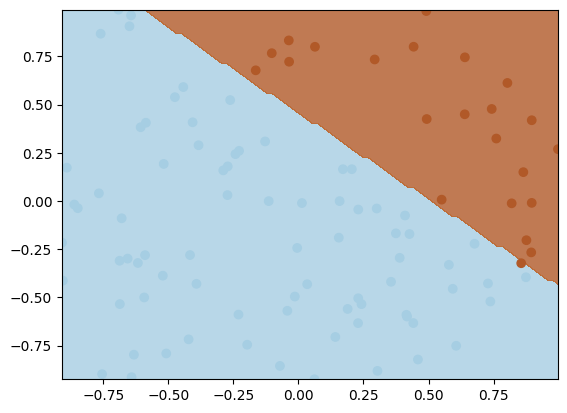

In [39]:
clf = SVM(Kernel.linear(), 100)
test_linear_SVM(clf, 100)

SV number:  11


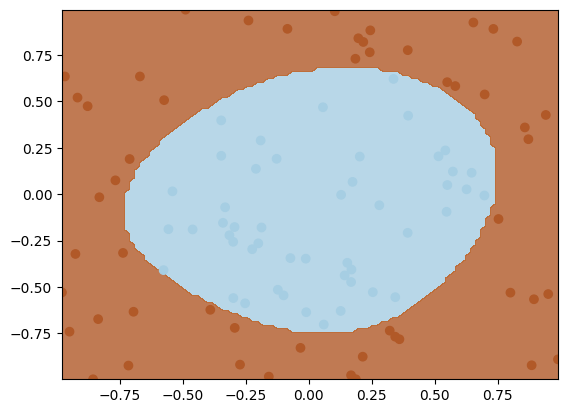

In [40]:
clf = SVM(Kernel.gaussian(1), 100)
test_rbf_SVM(clf, 100)

If you think your code is correct, then we can move to the real problem. Below are some code examples; you will need to fill in some details, and extend these to any experiments you want to run.

In [42]:
opt_C = None
opt_acc = float('inf')

for C in [0.5, 1, 5]:
   clf = SVM(Kernel.linear(), C)
   clf.fit(X['train'], y['train'].astype('double'))
   print("C = ", C)
   y_hat = clf.predict(X['train'])
   print("Acc on train: ", np.mean(y_hat == y['train']))
   y_hat = clf.predict(X['val'])
   print("Acc on val: ", np.mean(y_hat == y['val']))
   
   val_acc = np.mean(y_hat == y['val'])
   if val_acc < opt_acc:
      opt_acc = val_acc
      opt_C = C

SV number:  1365
C =  0.5
Acc on train:  0.9408795962509012
Acc on val:  0.728
SV number:  1268
C =  1
Acc on train:  0.9567411679884643
Acc on val:  0.724
SV number:  1099
C =  5
Acc on train:  0.9873828406633021
Acc on val:  0.73


Choose the best C, and predict the label for test data.

In [86]:
C = opt_C
clf = SVM(Kernel.linear(), C)
clf.fit(X['train'], y['train'].astype('double'))
y_hat = clf.predict(X['test'])
save_submission('sub_linear.csv', y_hat)

SV number:  1040


RBF (Gaussian) kernel SVM

In [43]:
opt_C, opt_gamma = None, None
opt_acc = float('inf')

for C in [0.5, 1]:
    for gamma in [0.01, 1, 5]:
        clf = SVM(Kernel.gaussian(gamma), C)
        clf.fit(X['train'], y['train'].astype('double'))
        print("C = ", C)
        print("gamma = ", gamma)
        y_hat = clf.predict(X['train'])
        print("Acc on train: ", np.mean(y_hat == y['train']))   
        y_hat = clf.predict(X['val'])
        print("Acc on val: ", np.mean(y_hat == y['val']))
        
        val_acc = np.mean(y_hat == y['val'])
        if val_acc < opt_acc:
            opt_acc = val_acc
            opt_C = C
            opt_gamma = gamma

SV number:  2112
C =  0.5
gamma =  0.01
Acc on train:  0.7184571016582553
Acc on val:  0.7
SV number:  2774
C =  0.5
gamma =  1
Acc on train:  0.6373467916366258
Acc on val:  0.67
SV number:  2774
C =  0.5
gamma =  5
Acc on train:  0.6380677721701514
Acc on val:  0.67
SV number:  2024
C =  1
gamma =  0.01
Acc on train:  0.7919971160778659
Acc on val:  0.706
SV number:  2774
C =  1
gamma =  1
Acc on train:  1.0
Acc on val:  0.67
SV number:  2774
C =  1
gamma =  5
Acc on train:  1.0
Acc on val:  0.67


In [44]:
clf = SVM(Kernel.gaussian(opt_gamma), opt_C)
clf.fit(X['train'], y['train'].astype('double'))
y_hat = clf.predict(X['test'])
save_submission('sub_rbf.csv', y_hat)

SV number:  2774
